### 1. Clean raw answers

In [1]:
import pandas as pd
import numpy as np
import re
import os

# List of CSV files representing different tasks
csv_files = [
    './type1_results.csv',
    './type2_results.csv',
    './type3_results.csv',
    './type4_results.csv',
    './type5_results.csv',
]


def clean_raw_answers(file_path):
    """
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: DataFrame with cleaned parsed answers
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Define a function to extract the last decimal value or fraction, evaluating fractions if necessary
    def extract_last_decimal_or_fraction(raw_answer):
        # Convert raw_answer to string to handle cases with division or decimals
        raw_answer = str(raw_answer)
        
        # Find all fractions and decimals
        fraction_matches = re.findall(r'\d+/\d+', raw_answer)
        decimal_matches = re.findall(r'0\.\d{1,3}', raw_answer)
        
        # Combine all matches into a single list (fractions first, then decimals)
        all_matches = fraction_matches + decimal_matches
        
        # If we found any matches, process the last one
        if all_matches:
            last_match = all_matches[-1]
            # Check if the last match is a fraction
            if '/' in last_match:
                # Evaluate the fraction and round to 2 decimal places as a string, stripping trailing zeros
                fraction_value = eval(last_match)
                return float(f"{fraction_value:.2f}".rstrip('0').rstrip('.'))
            else:
                # Strip trailing zeros from decimal format directly
                return float(last_match.rstrip('0').rstrip('.'))
        
        # Return NaN if no matches are found
        return np.nan
    
    # Apply the function to extract values and create a new column for the parsed answer
    df['parsed_answer'] = df['raw_answers'].apply(extract_last_decimal_or_fraction)
    
    return df

# Define the directory path containing the CSV files
csv_dir = "/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP3-Results"

# List of CSV files in the directory
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('_results.csv')]


# Dictionary to store cleaned DataFrames for each file
cleaned_dataframes = {}
for file_path in csv_files:
    try:
        # Clean each CSV file and store the DataFrame in cleaned_dataframes dictionary
        cleaned_df = clean_raw_answers(file_path)
        filename = os.path.basename(file_path).replace("_results.csv", "")
        cleaned_dataframes[filename] = cleaned_df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Access each cleaned DataFrame by task name
df_type1 = cleaned_dataframes.get('type1')
df_type2 = cleaned_dataframes.get('type2')
df_type3 = cleaned_dataframes.get('type3')
df_type4 = cleaned_dataframes.get('type4')
df_type5 = cleaned_dataframes.get('type5')


### 2. Drop n/a value - check rows has n/a value

In [2]:
# Task names to iterate over
task_names = ['type1', 'type2', 'type3', 'type4', 'type5']

# List to collect rows with NaN values in parsed_answer
nan_rows_list = []

# Iterate over each task name, retrieve the DataFrame, and collect NaN rows
for task_name in task_names:
    df = cleaned_dataframes.get(task_name)
    if df is not None:  # Ensure DataFrame exists
        # Identify rows with NaN in 'parsed_answer' and add them to the list
        nan_rows = df[df['parsed_answer'].isna()].copy()
        nan_rows['task_name'] = task_name  # Add task name as a column for identification
        nan_rows_list.append(nan_rows)

# Combine all NaN rows into a single DataFrame
nan_rows_df = pd.concat(nan_rows_list, ignore_index=True)

# Display the combined DataFrame with all NaN rows
print("\nAll rows with NaN values in 'parsed_answer' across tasks:")
nan_rows_df.head()



All rows with NaN values in 'parsed_answer' across tasks:


,model_name,run,image_path,ground_truth,raw_answers,forced_repetitions,parsed_answer,task_name
0,gpt4o,average,NaN,NaN,NaN,0,NaN,type1
1,CustomLLaMA,average,NaN,NaN,NaN,0,NaN,type1
2,LLaMA,run_2,EXP3-Results/type1/type1_image_13.png,0.478261,"user\n\nIn the grouped bar chart, compare the ...",0,NaN,type1
3,LLaMA,average,NaN,NaN,NaN,0,NaN,type1
4,GeminiProVision,average,NaN,NaN,NaN,0,NaN,type1


### 4. Display all 2 images tasks

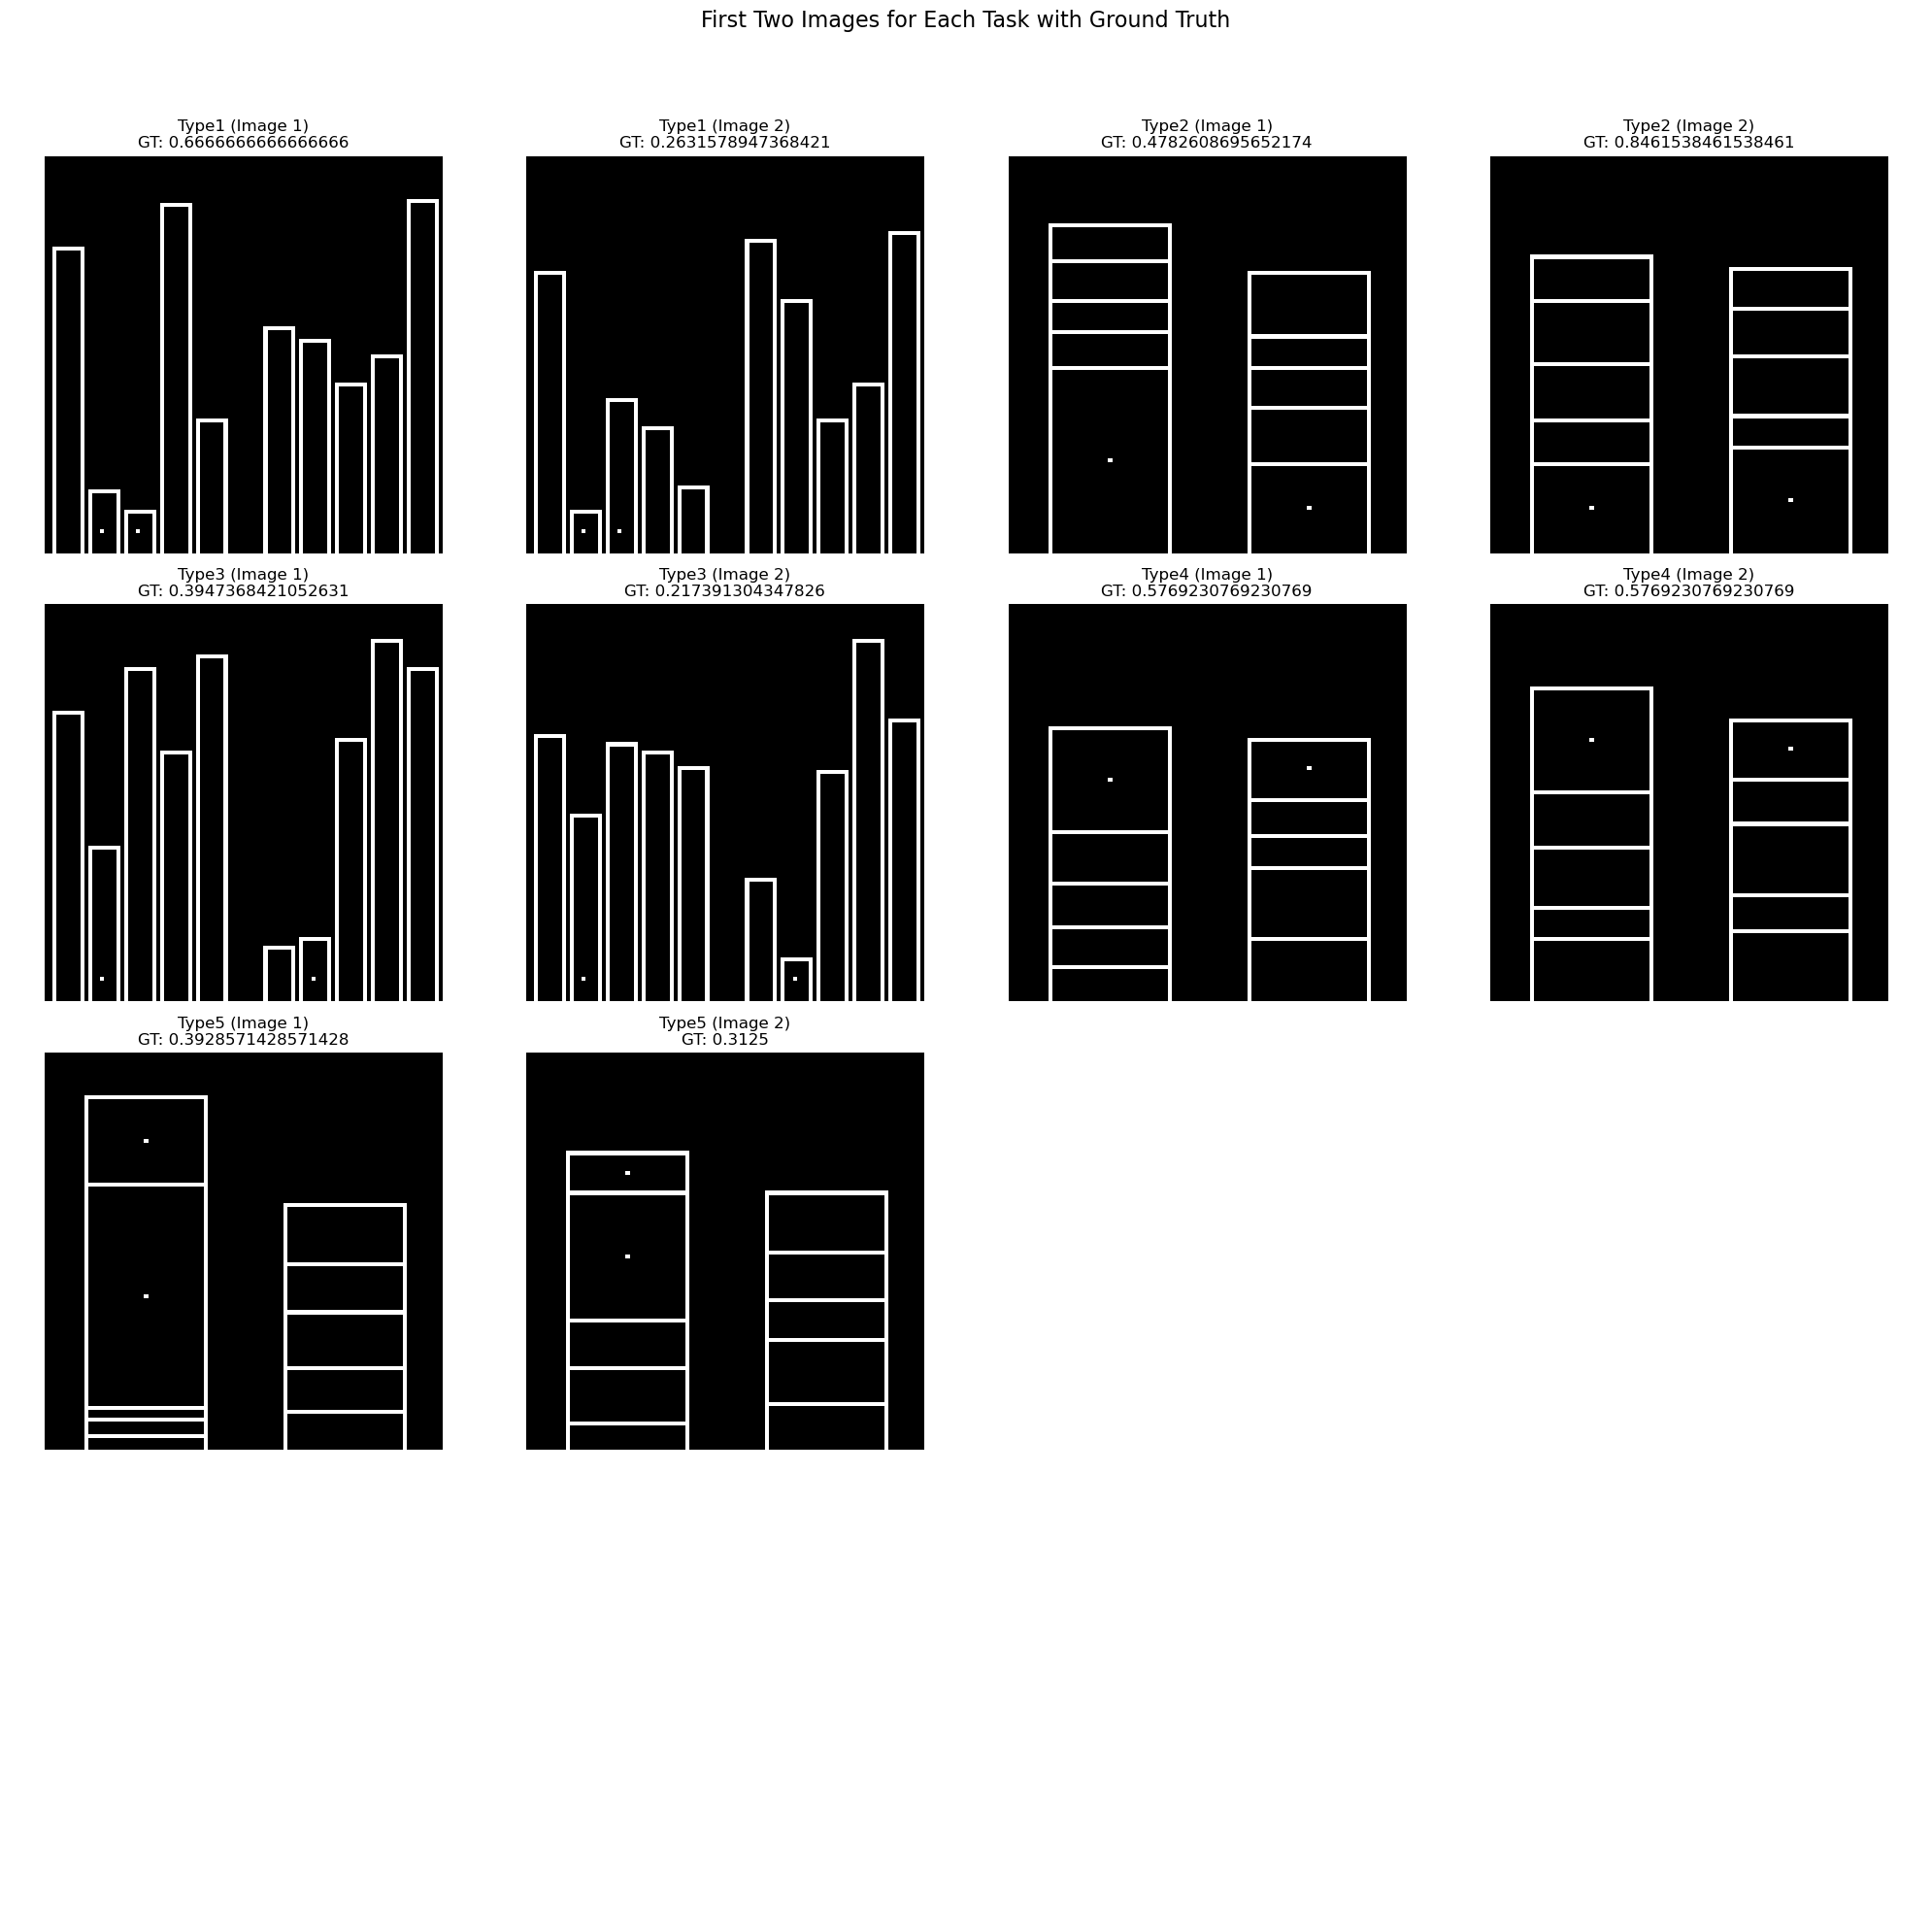

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# List of CSV files to read
csv_files = [
    './type1_results.csv',
    './type2_results.csv',
    './type3_results.csv',
    './type4_results.csv',
    './type5_results.csv',
]

# Number of columns and rows for the plot grid
num_cols = 4
num_rows = 4  # Adjusted to fit two images per task

# Create a figure with subplots for displaying images in a 5x5 grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig.suptitle("First Two Images for Each Task with Ground Truth", fontsize=16)

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Track the subplot index
subplot_idx = 0

# Loop through each CSV file and display the first two images for each task
for csv_file in csv_files:
    # Check if CSV file exists
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        continue

    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Extract the task name from the CSV filename (e.g., 'type1' from 'type1_results.csv')
    task = os.path.basename(csv_file).replace('_results.csv', '')

    # Loop through the first two rows to display two images for each task
    for i in range(2):  # Get the first two images
        if subplot_idx >= num_rows * num_cols:
            print("No more subplots available.")
            break

        if i >= len(results_df):
            print(f"Not enough images in {csv_file} to display two images.")
            break
        
        row = results_df.iloc[i]
        
        # Use the full image path from the "image_path" column, joined with the base_folder
        image_filename = os.path.basename(row["image_path"])
        image_path = os.path.join(base_folder, task, image_filename)
        ground_truth = row["ground_truth"]

        # Display the image in the subplot
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[subplot_idx].imshow(img, cmap="gray")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nGT: {ground_truth}")
        else:
            print(f"Image not found: {image_path}")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nImage not found")
        
        axes[subplot_idx].axis("off")
        subplot_idx += 1

# Hide any remaining empty subplots
for j in range(subplot_idx, num_rows * num_cols):
    axes[j].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout and title spacing
plt.show()


In [45]:
df_type1.head()

,model_name,run,image_path,ground_truth,raw_answers,forced_repetitions,parsed_answer
0,gpt4o,run_0,EXP3-Results/type1/type1_image_1.png,0.326087,0.6,0,0.60
1,gpt4o,run_0,EXP3-Results/type1/type1_image_2.png,0.461538,0.5,0,0.50
2,gpt4o,run_0,EXP3-Results/type1/type1_image_3.png,0.555556,0.75,0,0.75
3,gpt4o,run_0,EXP3-Results/type1/type1_image_4.png,0.315789,0.6,0,0.60
4,gpt4o,run_0,EXP3-Results/type1/type1_image_5.png,0.666667,0.5,0,0.50


### 5. Caculate all metrics

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# Assuming df_type1 to df_type5 are already defined as DataFrames
dataframes = {
    'type1': df_type1,
    'type2': df_type2,
    'type3': df_type3,
    'type4': df_type4,
    'type5': df_type5
}

metrics_summary = {}

# Loop through each dataset
for df_name, df in dataframes.items():
    model_metrics = {}
    
    # Group by `model_name` and calculate metrics for each model
    for model_name, data in df.groupby('model_name'):
        # Ensure columns are numeric, converting non-numeric values to NaN
        data['ground_truth'] = pd.to_numeric(data['ground_truth'], errors='coerce')
        data['parsed_answer'] = pd.to_numeric(data['parsed_answer'], errors='coerce')  # Use 'parsed_answer' here
        
        # Drop rows with NaN in `ground_truth` or `parsed_answer`
        data = data.dropna(subset=['ground_truth', 'parsed_answer'])
        
        # Calculate Mean and Standard Deviation of `parsed_answer`
        mean_parsed_answers = data['parsed_answer'].mean()
        std_parsed_answers = data['parsed_answer'].std()
        
        # Calculate Mean Squared Error (MSE)
        data['mse'] = (data['ground_truth'] - data['parsed_answer']) ** 2
        avg_mse = data['mse'].mean()
        
        # Calculate Mean Log Absolute Error (MLAE)
        # Since mean_absolute_error expects arrays, we use `abs()` manually for single values
        data['mlae'] = data.apply(
            lambda row: np.log2(abs(row['ground_truth'] - row['parsed_answer']) + 0.125),
            axis=1
        )
        
        # Calculate average MLAE, standard deviation, and confidence interval for MLAE
        avg_mlae = data['mlae'].mean()
        std_mlae = data['mlae'].std()
        
        mlae_values = data['mlae'].dropna().values
        bootstrap_result = bs.bootstrap(np.array(mlae_values), stat_func=bs_stats.std)
        confidence_value = 1.96 * bootstrap_result.value  # 95% confidence interval margin

        # Store metrics in the model_metrics
        model_metrics[model_name] = {
            'Dataset': df_name,
            'Model': model_name,
            'Average MLAE': round(avg_mlae, 2),
            'Std MLAE': round(std_mlae, 2),
            'Confidence Interval (95%)': round(confidence_value, 2)
        }
    
    metrics_summary[df_name] = model_metrics

# Convert metrics_summary to a DataFrame for viewing
metrics_table = pd.DataFrame([
    metrics for dataset_metrics in metrics_summary.values() for metrics in dataset_metrics.values()
])

metrics_table


/tmp/ipykernel_3325806/3197349715.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mse'] = (data['ground_truth'] - data['parsed_answer']) ** 2
/tmp/ipykernel_3325806/3197349715.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mlae'] = data.apply(
/tmp/ipykernel_3325806/3197349715.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

,Dataset,Model,Average MLAE,Std MLAE,Confidence Interval (95%)
0,type1,CustomLLaMA,-2.72,0.35,0.68
1,type1,Gemini1_5Flash,-1.80,0.58,1.12
2,type1,GeminiProVision,-1.46,0.71,1.37
3,type1,LLaMA,-1.83,0.74,1.44
4,type1,gpt4o,-1.69,0.58,1.13
5,type2,CustomLLaMA,-2.78,0.22,0.43
6,type2,Gemini1_5Flash,-1.87,0.68,1.31
7,type2,GeminiProVision,-1.23,0.57,1.10
8,type2,LLaMA,-1.75,0.66,1.28
9,type2,gpt4o,-1.77,0.61,1.18


### 6. Plot MLAE for all models


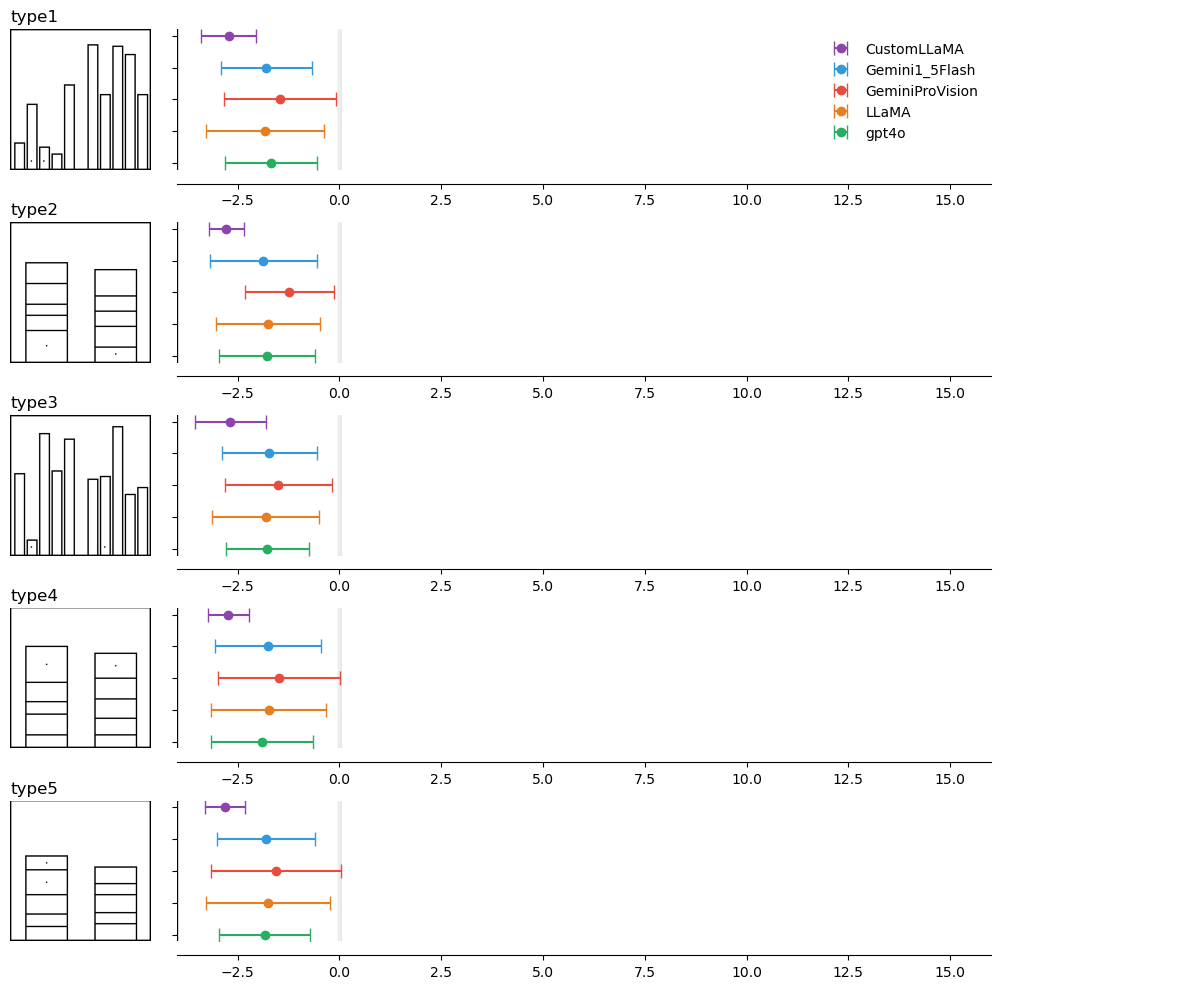

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os

import os

# Group data by dataset for easier access
summary_stats_by_task = {df_name: metrics_table[metrics_table['Dataset'] == df_name] for df_name in metrics_table['Dataset'].unique()}

# Set the base directory
base_dir = '/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP3-Results-test'

# Define task images relative to the base directory for each type
task_images = {
    'type1': os.path.join(base_dir, 'type1', 'type1_image_1.png'),
    'type2': os.path.join(base_dir, 'type2', 'type2_image_1.png'),
    'type3': os.path.join(base_dir, 'type3', 'type3_image_1.png'),
    'type4': os.path.join(base_dir, 'type4', 'type4_image_1.png'),
    'type5': os.path.join(base_dir, 'type5', 'type5_image_1.png')
}

# Check if each path exists and print
#for task, img_path in task_images.items():
    #print(f"Path for {task}: {img_path} - Exists: {os.path.isfile(img_path)}")


# Define colors for each model
model_colors = {
    'CustomLLaMA': '#8E44AD',       # Purple
    'Gemini1_5Flash': '#3498DB',    # Blue
    'GeminiProVision': '#E74C3C',   # Red
    'LLaMA': '#E67E22',             # Orange
    'gpt4o': '#27AE60'              # Green
}

# Plot configuration
num_tasks = len(summary_stats_by_task)
fig, axes = plt.subplots(num_tasks, 3, figsize=(12, 2 * num_tasks), 
                         gridspec_kw={'width_ratios': [1, 5, 1]}, sharex=False)
fig.subplots_adjust(hspace=0.5, wspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.patch.set_facecolor('white')

# Convert `axes` to 2D array if only one row of subplots
if num_tasks == 1:
    axes = axes.reshape(1, -1)

# Loop through each task (dataset) and its summary stats
for i, (task_name, task_data) in enumerate(summary_stats_by_task.items()):
    ax_img, ax_plot, ax_label = axes[i]

    # Clean task name to match keys in `task_images`
    cleaned_task_name = task_name.replace("df_", "")
    
    # Use the cleaned name to access the correct image path
    img_path = task_images.get(cleaned_task_name)
    
    # Display task image if available
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert("L")
            img_inverted = ImageOps.invert(img)
            img_with_border = ImageOps.expand(img_inverted.convert("RGB"), border=1, fill="black")
            ax_img.imshow(img_with_border)
            ax_img.axis('off')  # Hide axes for the image plot

        except Exception as e:
            #print(f"Error displaying image for {task_name}: {e}")
            ax_img.text(0.5, 0.5, "Error displaying image", ha="center", va="center", fontsize=10, color="black")
            ax_img.set_facecolor("white")
    else:
        #print(f"Image not found: {img_path}")
        ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=10, color="black")
        ax_img.set_facecolor("white")

    # Sort model names alphabetically and get y positions
    sorted_model_names = sorted(task_data['Model'].unique())
    y_positions = np.arange(len(sorted_model_names))

    # Plot MLAE and error bars in the middle
    for j, model_name in enumerate(sorted_model_names):
        model_data = task_data[task_data['Model'] == model_name]
        mlae_value = model_data['Average MLAE'].values[0]
        confidence_interval = model_data['Confidence Interval (95%)'].values[0]

        ax_plot.errorbar(mlae_value, j, xerr=confidence_interval, fmt='o', 
                         color=model_colors.get(model_name, 'gray'), capsize=5, 
                         label=f"{model_name}" if i == 0 else None)

    # Add reference lines
    ax_plot.axvline(-4, color="black", linewidth=1)
    ax_plot.axvline(-14, color="black", linewidth=1)
    
    # Add blurred line at 0
    for offset in np.linspace(-0.05, 0.05, 10):
        ax_plot.axvline(0 + offset, color="gray", alpha=0.1, linewidth=0.5)

    # Customize plot appearance
    ax_plot.grid(False)
    ax_plot.spines['top'].set_visible(False)
    ax_plot.spines['right'].set_visible(False)
    ax_plot.spines['left'].set_visible(False)
    ax_plot.spines['bottom'].set_position(('outward', 10))

    # Set axis properties
    ax_plot.set_yticks(y_positions)
    ax_plot.set_yticklabels([])
    ax_plot.set_xlim(-4, 16)
    ax_plot.invert_yaxis()

    # Clean task name and set title
    cleaned_task_name = task_name.replace("df_", "")
    ax_img.set_title(cleaned_task_name, loc="left", fontsize=12, color="black")

    # Configure right labels
    ax_label.set_yticks(y_positions)
    ax_label.set_yticklabels(sorted_model_names, fontsize=10)
    ax_label.tick_params(left=False, right=False, labelleft=False, labelright=True)
    ax_label.set_ylim(ax_plot.get_ylim())
    ax_label.axis("off")

# Add legend to the first row
axes[0, 1].legend(loc="best", frameon=False)

# Ensure tight layout
plt.tight_layout()
plt.show()


### 7. Filter and sort model data

In [7]:
filtered_df_type5 = df_type5[df_type5['model_name'] == 'Gemini1_5Flash']
filtered_df_type5

,model_name,run,image_path,ground_truth,raw_answers,forced_repetitions,parsed_answer
244,Gemini1_5Flash,run_0,EXP3-Results/type5/type5_image_1.png,0.392857,0.5 \n,0,0.50
245,Gemini1_5Flash,run_0,EXP3-Results/type5/type5_image_2.png,0.312500,0.6 \n,0,0.60
246,Gemini1_5Flash,run_0,EXP3-Results/type5/type5_image_3.png,0.392857,0.6 \n,0,0.60
247,Gemini1_5Flash,run_0,EXP3-Results/type5/type5_image_4.png,0.545455,0.5 \n,0,0.50
248,Gemini1_5Flash,run_0,EXP3-Results/type5/type5_image_5.png,0.545455,0.65 \n,0,0.65
...,...,...,...,...,...,...,...
300,Gemini1_5Flash,run_2,EXP3-Results/type5/type5_image_17.png,0.695652,0.65 \n,0,0.65
301,Gemini1_5Flash,run_2,EXP3-Results/type5/type5_image_18.png,0.214286,0.65 \n,0,0.65
302,Gemini1_5Flash,run_2,EXP3-Results/type5/type5_image_19.png,0.260870,0.25 \n,0,0.25
303,Gemini1_5Flash,run_2,EXP3-Results/type5/type5_image_20.png,0.842105,0.65 \n,0,0.65


### 8. Display 5 images for each task

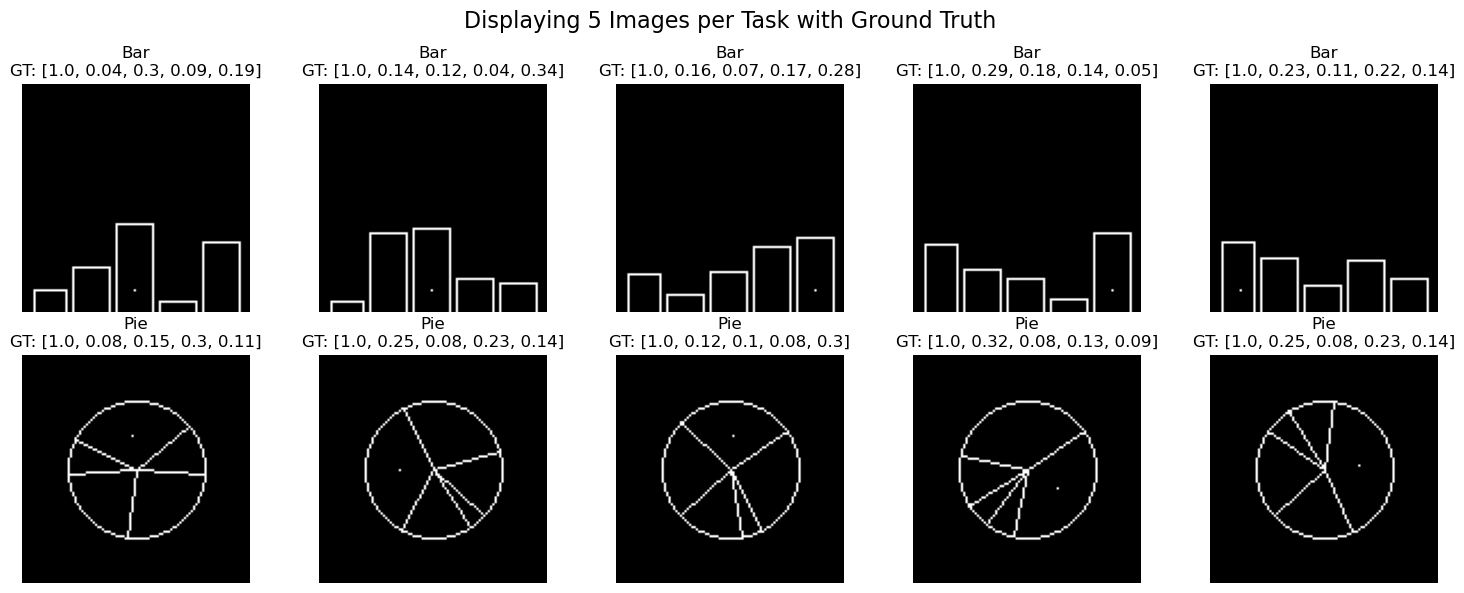

In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# Dictionary of CSV files for each task
csv_files = {
    'bar': './bar_results.csv', 
    'pie': './pie_results.csv'
}

def display_images(num_images, tasks="all"):
    """
    Display a specified number of images for selected tasks with ground truth labels.
    
    Parameters:
    - num_images: int, the number of images to display per task
    - tasks: list or "all", specifies which tasks to display images for
    """
    # Use all tasks if 'tasks' parameter is "all"
    selected_tasks = list(csv_files.keys()) if tasks == "all" else tasks

    # Calculate total number of subplots needed
    total_images = len(selected_tasks) * num_images
    num_cols = 5
    num_rows = (total_images + num_cols - 1) // num_cols  # Automatically adjust rows

    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    fig.suptitle(f"Displaying {num_images} Images per Task with Ground Truth", fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()

    plot_idx = 0  # To keep track of the current subplot index
    for task in selected_tasks:
        # Check if the CSV file exists for the task
        csv_file = csv_files.get(task)
        if not os.path.exists(csv_file):
            print(f"CSV file not found: {csv_file}")
            continue

        # Load CSV data
        results_df = pd.read_csv(csv_file)

        # Limit to num_images or the number of rows in the CSV, whichever is smaller
        num_to_display = min(num_images, len(results_df))

        # Loop to display each image for the task
        for i in range(num_to_display):
            if plot_idx >= num_rows * num_cols:
                break
            
            # Get the row data and image path
            row = results_df.iloc[i]
            image_filename = row["image_path"]

            # Check if image path is a valid string before proceeding
            if pd.isna(image_filename) or not isinstance(image_filename, str):
                print(f"Invalid image path for {task}, row {i}: {image_filename}")
                axes[plot_idx].set_title(f"{task.capitalize()}\nInvalid Image Path")
                axes[plot_idx].axis("off")
                plot_idx += 1
                continue

            image_path = os.path.join(base_folder, task, os.path.basename(image_filename))
            ground_truth = row["ground_truth"]

            # Display image if exists, else show 'Image not found'
            if os.path.exists(image_path):
                img = Image.open(image_path)
                axes[plot_idx].imshow(img, cmap="gray")
                axes[plot_idx].set_title(f"{task.capitalize()}\nGT: {ground_truth}")
            else:
                print(f"Image not found: {image_path}")
                axes[plot_idx].set_title(f"{task.capitalize()}\nImage not found")

            axes[plot_idx].axis("off")
            plot_idx += 1

    # Hide any remaining empty subplots
    for j in range(plot_idx, num_rows * num_cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage to display images from bar and pie tasks
display_images(num_images=5, tasks=["bar", "pie"])
